In [67]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage


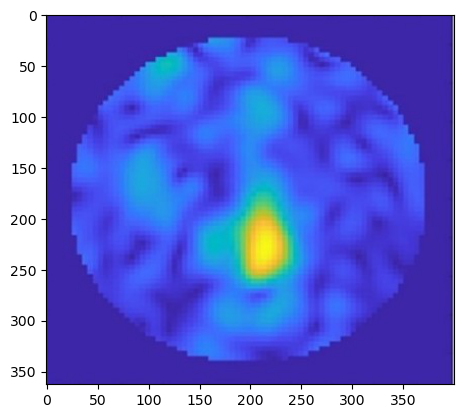

In [68]:
image=plt.imread("maligant.jpg")
image.shape
plt.imshow(image)

In [69]:
gray=cv2.imread("maligant.jpg",cv2.IMREAD_GRAYSCALE)
gray.shape

(363, 400)

In [70]:
gray_r =gray.reshape(gray.shape[0]*gray.shape[1])
gray_r.shape

(145200,)

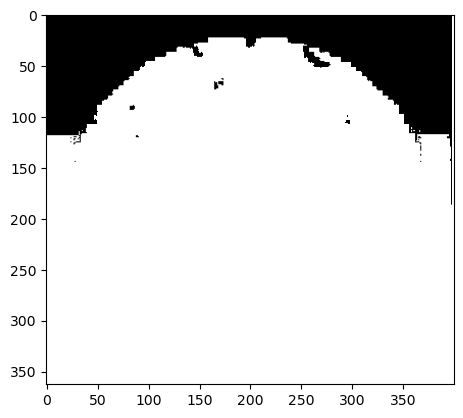

In [71]:
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean(0):
        gray_r[i]=1
    else:
        gray_r[i]=0
gray=gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

In [72]:
#defining the sobel filters
sobel_horizontal =np.array([np.array([1,2,1]), np.array([0,0,0]), np.array([-1,-2,-1])])
print(sobel_horizontal,"is a kernel for detection horizontal edges")

sobel_vertical=np.array([np.array([-1,0,1]),np.array([-2,0,2]), np.array([-1,0,1])])
print(sobel_vertical,"is a kernel for detection  vertical range")

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]] is a kernel for detection horizontal edges
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]] is a kernel for detection  vertical range


In [73]:
out_h=ndimage.convolve(gray,sobel_horizontal, mode="reflect")
out_v=ndimage.convolve(gray, sobel_vertical, mode="reflect")

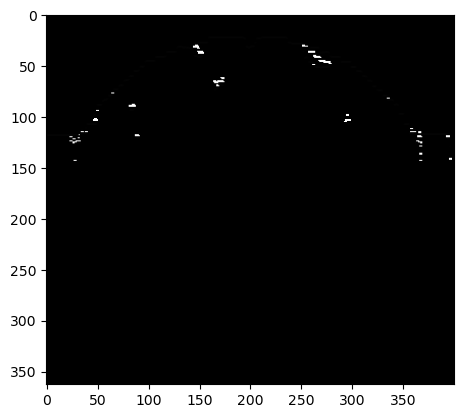

In [74]:
plt.imshow(out_v, cmap="gray")
plt.imshow(out_h, cmap="gray")

In [75]:
kernel_laplace=np.array([np.array([1,1,1]), np.array([1,-8,1]), np.array([1,1,1])])
print(kernel_laplace,"is a laplacian kernel")

[[ 1  1  1]
 [ 1 -8  1]
 [ 1  1  1]] is a laplacian kernel


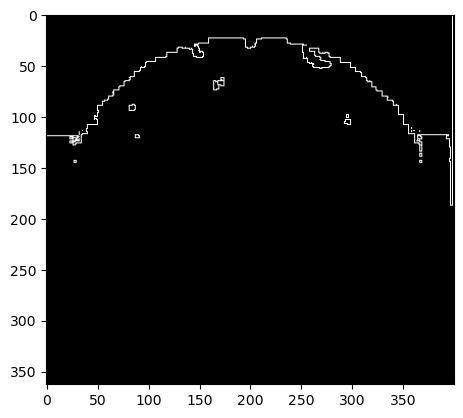

In [76]:
out_l=ndimage.convolve(gray, kernel_laplace, mode="reflect")
plt.imshow(out_l, cmap="gray")

(363, 400, 3)


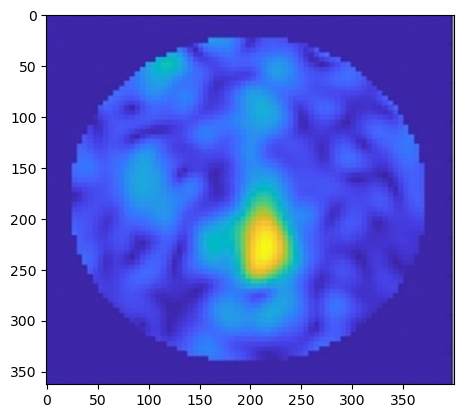

In [77]:
pic =plt.imread("maligant.jpg")/255
print(pic.shape)
plt.imshow(pic)

In [78]:
pic_n =pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape

(145200, 3)

In [87]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6,random_state=42).fit(pic_n)
pic2show =kmeans.cluster_centers_[kmeans.labels_]

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


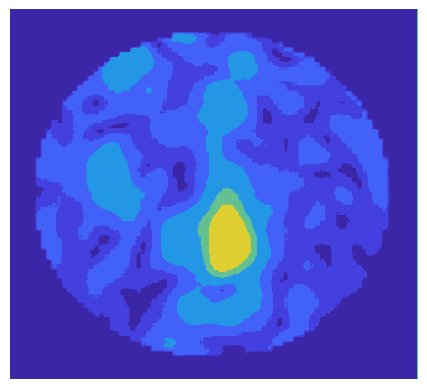

In [88]:
cluster_pic =pic2show. reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)
plt.axis("off")
plt.show()

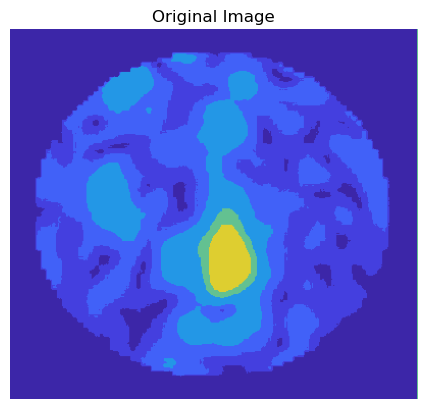

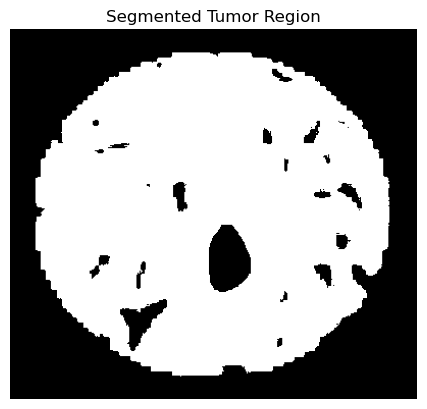

In [89]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings

def segment_tumor(image):
    # Height and width of the image
    height, width, _ = image.shape

    # Reshape the image to a 2D array of pixels
    pixels = image.reshape((height * width, 3))

    # Suppress FutureWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Use k-means clustering for segmentation (assuming tumor and background)
        kmeans = KMeans(n_clusters=2, n_init=10)  # Explicitly set n_init
        kmeans.fit(pixels)

    # Get the labels assigned to each pixel
    segmented_image = kmeans.labels_.reshape((height, width))

    # Extract the region corresponding to the tumor
    tumor_region = np.where(segmented_image == 1, 255, 0).astype(np.uint8)
    
    return tumor_region

# Assuming pic2show contains the original image represented as a NumPy array
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])

# Segment the tumor region using the segment_tumor function
segmented_tumor_region = segment_tumor(cluster_pic)

# Display the original image
plt.imshow(cluster_pic)
plt.axis("off")
plt.title("Original Image")
plt.show()

# Display the segmented tumor region
plt.imshow(segmented_tumor_region,cmap="gray")
plt.axis("off")
plt.title("Segmented Tumor Region")
plt.show()


In [90]:
def calculate_tumor_diameter(image_copy, pixel_to_cm_conversion):
    # Find contours in the segmented tumor region
    contours, _ = cv2.findContours(segmented_tumor_region, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)#retrives the external holes

    # Find the contour with the maximum area (assuming it corresponds to the tumor)
    if contours:
        max_contour =max(contours, key=cv2.contourArea)

        # Calculate the area of the contour (tumor size)
        tumor_area = cv2.contourArea(max_contour)

        # Calculate the equivalent diameter using the formula: diameter = 2 * sqrt(area / π)
        tumor_diameter = 4 * np.sqrt(tumor_area / np.pi)

        # Convert diameter to centimeters using the pixel-to-cm conversion factor
        tumor_diameter_cm = tumor_diameter * pixel_to_cm_conversion

        return tumor_diameter_cm
    else:
        
        print("No contours found. Tumor not detected.")
        return 0

# Example usage
#image_path = cluster_pic

pixel_to_cm_conversion = 0.01  # Example: 1 pixel represents 0.01 centimeters
#umor_region = segment_tumor(image_path)

tumor_diameter_cm = calculate_tumor_diameter(segmented_tumor_region, pixel_to_cm_conversion)
print(f"Tumor Diameter: {tumor_diameter_cm} centimeters")

Tumor Diameter: 6.633065385781328 centimeters


In [91]:
def classify_tumor(image_path, threshold_area=500, circularity_threshold=0.7):
   
    # Read the color image
    img = cv2.imread(image_path)
    
     # Check if the image is loaded successfully
    if img is None:
        print("Error: Unable to read the image from the provided path:", image_path)
        return None

    # Convert it to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur for noise reduction
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply morphological operations (closing) to enhance structures
    kernel = np.ones((15, 15), np.uint8)
    img_closed = cv2.morphologyEx(gray_blurred, cv2.MORPH_CLOSE, kernel)

    # Apply adaptive thresholding to segment the image
    img_threshold = cv2.adaptiveThreshold(img_closed, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(img_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Analyze the contours to determine if they indicate tumors
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > threshold_area:
            # Calculate circularity of the contour
            perimeter = cv2.arcLength(contour, True)
            circularity = (4 * np.pi * area) / (perimeter * perimeter)

            # Classify as benign or malignant based on circularity
            if circularity > circularity_threshold:
                classification = 'Malignant'
            else:
                classification = 'Benign'

            return classification  # Return the classification without displaying the image

    return None  # Return None if no tumor is detected

# Example usage
image_path_to_analyze = "maligant.jpg"
result = classify_tumor(image_path_to_analyze)

if result is not None:
    print(f'Tumor classification: {result}')
else:
    print('No tumor detected.')

Tumor classification: Malignant
